In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from seaborn import kdeplot
import numpy as np
from zipfile import ZipFile
import os

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [3]:
directory = os.listdir('C:/DATASETS/IBGE/PNAD')

#### Carregamento de dados no formato .fwf
[0][0:]pesquisas [1][0:] dicionarios || [0][0:]subdiretórios [1][0:]dicionarios [2][0:]microdados

In [4]:
def loadData(directory, n_fields=220, lastPos=3478):
    with ZipFile(f'C:/DATASETS/IBGE/PNAD/Dicionario_e_input_20220224.zip') as z:
        df_dict = pd.read_excel(z.open(z.namelist()[0]), header=None, 
                              skiprows=4, dtype='string').dropna(how='all')[[0, 1, 2, 4, 5, 6]]

        sizes = df_dict[1][df_dict[1].str.isnumeric()].astype(int).values
        positions = df_dict[0][df_dict[0].str.isnumeric()].astype(int).values-1
        final_pos = [i[0]+i[1] for i in zip(positions, sizes)]
        final_pos[n_fields], final_pos = lastPos, final_pos[0:n_fields]
        tuples = list(zip(positions, final_pos))
    #tamanhos das colunas a partir do dicionário de dados

    with ZipFile(f'C:/DATASETS/IBGE/PNAD/{directory}') as z:
        pnad = pd.read_fwf(z.open(z.namelist()[0]),
                              colspecs=tuples, header=None, dtype=str)

    df_dict.fillna(value=None, method='ffill', inplace=True)
    df_dict.set_index(2, inplace=True)
    df_dict.index = df_dict.index.str.lower()
    pnad.columns = list(df_dict.index.str.lower().dropna().unique()[0:n_fields])
    
    return pnad

In [5]:
pnad = loadData(directory=directory[1], n_fields=220, lastPos=3478) #dataset carregado
# pnad2 = loadData(directory=directory[2], n_fields=220, lastPos=3478)
# pnad = pd.concat([pnad, pnad2])
# del pnad2

In [6]:
with ZipFile(f'C:/DATASETS/IBGE/PNAD/Dicionario_e_input_20220224.zip') as z: #dicionário de variaveis
        df_dict = pd.read_excel(z.open(z.namelist()[0]), header=None, 
                              skiprows=4, dtype='string').dropna(how='all')[[0, 1, 2, 4, 5, 6]]

df_dict[2].fillna(method='ffill', inplace=True)
df_dict.set_index(2, inplace=True)
df_dict.index = df_dict.index.str.lower()

### Remoção de domicílios duplicados
• O método de amostragem da pnad contínua

In [7]:
pnad = pnad[pnad[['upa', 'estrato', 'v1008', 'v2003']].duplicated()==False]
pnad.reset_index(drop=True, inplace=True)

In [8]:
pnad.head(3)

,ano,trimestre,uf,capital,rm_ride,upa,estrato,v1008,v1014,v1016,v1022,v1023,v1027,v1028,v1029,v1033,posest,posest_sxi,v2001,v2003,v2005,v2007,v2008,v20081,v20082,v2009,v2010,v3001,v3002,v3002a,v3003,v3003a,v3004,v3005,v3005a,v3006,v3006a,v3007,v3008,v3009,v3009a,v3010,v3011,v3011a,v3012,v3013,v3013a,v3013b,v3014,v4001,v4002,v4003,v4004,v4005,v4006,v4006a,v4007,v4008,v40081,v40082,v40083,v4009,v4010,v4012,v40121,v4013,v40132,v40132a,v4014,v4015,v40151,v401511,v401512,v4016,v40161,v40162,v40163,v4017,v40171,v401711,v4018,v40181,v40182,v40183,v4019,v4020,v4021,v4022,v4024,v4025,v4026,v4027,v4028,v4029,v4032,v4033,v40331,v403311,v403312,v40332,v403321,v403322,v40333,v403331,v4034,v40341,v403411,v403412,v40342,v403421,v403422,v4039,v4039c,v4040,v40401,v40402,v40403,v4041,v4043,v40431,v4044,v4045,v4046,v4047,v4048,v4049,v4050,v40501,v405011,v405012,v40502,v405021,v405022,v40503,v405031,v4051,v40511,v405111,v405112,v40512,v405121,v405122,v4056,v4056c,v4057,v4058,v40581,v405811,v405812,v40582,v405821,v405822,v40583,v405831,v40584,v4059,v40591,v405911,v405912,v40592,v405921,v405922,v4062,v4062c,v4063,v4063a,v4064,v4064a,v4071,v4072,v4072a,v4073,v4074,v4074a,v4075a,v4075a1,v4076,v40761,v40762,v40763,v4077,v4078,v4078a,v4082,vd2002,vd2003,vd2004,vd2006,vd3004,vd3005,vd3006,vd4001,vd4002,vd4003,vd4004,vd4004a,vd4005,vd4007,vd4008,vd4009,vd4010,vd4011,vd4012,vd4013,vd4014,vd4015,vd4016,vd4017,vd4018,vd4019,vd4020,vd4023,vd4030,vd4031,vd4032,vd4033,vd4034,vd4035,vd4036,vd4037
0,2022,1,11,11,NaN,110000016,1110011,02,09,3,1,1,000103.17156451,000156.52116685,000554024,007304041,111,210,05,01,01,2,99,99,9999,045,2,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,11,NaN,NaN,NaN,1,01,NaN,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5120,3,NaN,56011,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,06,NaN,NaN,1,1,NaN,NaN,2,NaN,NaN,NaN,1,NaN,1,1,3,00001410,NaN,NaN,NaN,NaN,NaN,1,1,3,00001410,NaN,NaN,NaN,044,044,4,NaN,NaN,05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01,05,3,10,4,10,4,1,1,NaN,NaN,NaN,NaN,1,1,01,06,05,1,3,3,1,00001410,00001410,1,00001410,00001410,NaN,NaN,044,NaN,NaN,NaN,044,3,3
1,2022,1,11,11,NaN,110000016,1110011,02,09,3,1,1,000103.17156451,000156.52116685,000554024,008515086,111,106,05,02,05,1,99,99,9999,026,2,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,11,NaN,NaN,NaN,1,01,NaN,NaN,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,2,03,05,3,06,4,10,4,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,1,11,11,NaN,110000016,1110011,02,09,3,1,1,000103.17156451,000156.52116685,000554024,009328304,111,104,05,03,05,1,10,06,2003,018,2,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,08,NaN,NaN,NaN,1,08,NaN,NaN,1,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,2,05,NaN,NaN,1,NaN,NaN,2,03,05,3,04,3,09,4,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [9]:
def cat_dict(df, var): #substituir códigos pelo nome da categoria
    catDict = dict()
    for n, cat in enumerate(df_dict.loc[var][5]):
        try:
            catDict[cat] = df_dict.loc[var][6][n].lower()
        except:
            pass
    return catDict

In [10]:
cat_dict(df_dict, 'v3002')

{'1': 'sim', '2': 'não ', <NA>: 'não aplicável'}

In [11]:
 def drop_min_obs(df, min_obs=10000): #excluir colunas que não tenha o min desejado de obs
    to_drop = list()
    for i in df.columns:
        n_obs = (df[i].isna()==False).sum()
        if n_obs<min_obs:
            to_drop.append(i)
        else:
            pass

    return df.drop(to_drop, axis=1, inplace=True)

In [12]:
variaveis = ['upa','estrato','v1008', 'v2007', 'v2009', 'v2010', 'v403312','vd3005']

def moradoresMesmoDomicilio(df, variaveis):
    respFilhos = df[df['v2005']=='01'][variaveis]\
                            .merge(df[(df['v2005']=='04')|(df['v2005']=='05')][variaveis],
                                       on=['upa', 'estrato', 'v1008'], how='inner', suffixes=['_r','_f'])


    filtro = (respFilhos['v2009_f'].astype(int)>25)
    respFilhos = respFilhos[filtro]
    respFilhos['vd3005_f'] = respFilhos['vd3005_f'].astype(int)

    respFilhos['domicilio'] = respFilhos['upa'] + respFilhos['estrato'] + respFilhos['v1008']
    respFilhos.drop(['upa', 'estrato', 'v1008'], axis=1, inplace=True)
    respFilhos['vd3005_r'] = respFilhos['vd3005_r'].astype(int)
    return respFilhos

In [13]:
respFilhos = moradoresMesmoDomicilio(pnad, variaveis)

In [14]:
steps = 4
def discretize(df, steps=4):
    labels = [str(x)+'a'+str(x+steps) if n==0 else str(x)+'a'+str(x+steps) if n == 0 else str(x+1)+'a'+str(x+steps)
                          for n, x in enumerate(np.unique(
                                               np.linspace(0, df['vd3005_r'].astype(int).max(), steps, endpoint=False)
                                                       ).astype(int)
                                                          )]
    df['vd3005_r_c'] = pd.cut(df['vd3005_r'].astype(int), bins=steps, labels=labels)
    return df

In [15]:
respFilhos = respFilhos.groupby(['domicilio']).mean().pipe(discretize, 4)
anosEstudados = respFilhos.groupby(['vd3005_r_c']).mean()

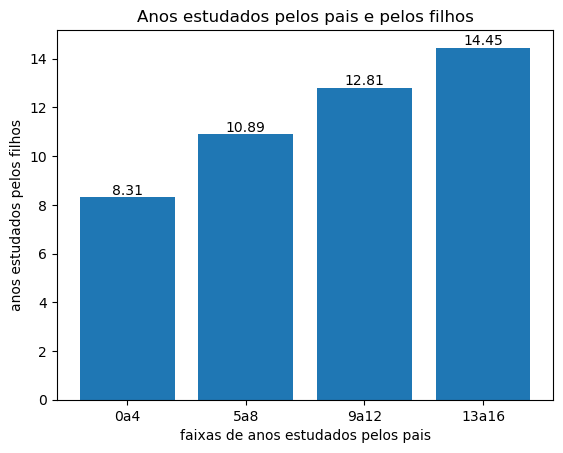

In [16]:
plt.title('Anos estudados pelos pais e pelos filhos')
plt.bar_label(
plt.bar(anosEstudados.index, anosEstudados['vd3005_f'].values.round(2)))
plt.ylabel('anos estudados pelos filhos'), plt.xlabel('faixas de anos estudados pelos pais')
plt.show()

• Com este gráfico, é possível ver a associação entre quantidade de anos estudados pelos filhos e pelos responsáveis
com diferença da média de anos estudados pelos filhos de 2,6 anos se comparado os responsáveis na faixa de 5 a 8 anos de estudos com os dos filhos de responsáveis na faixa de 0 a 4 anos de estudo. A diferença de média de anos estudados para as faixas de estudo seguintes (9 a 12 anos - 5 a 8 anos e 13 a 16 anos - 12 a 9 anos) dos responsáveis é de 1,9 anos.

In [17]:
respFilhos = moradoresMesmoDomicilio(pnad, variaveis).pipe(discretize, 4)

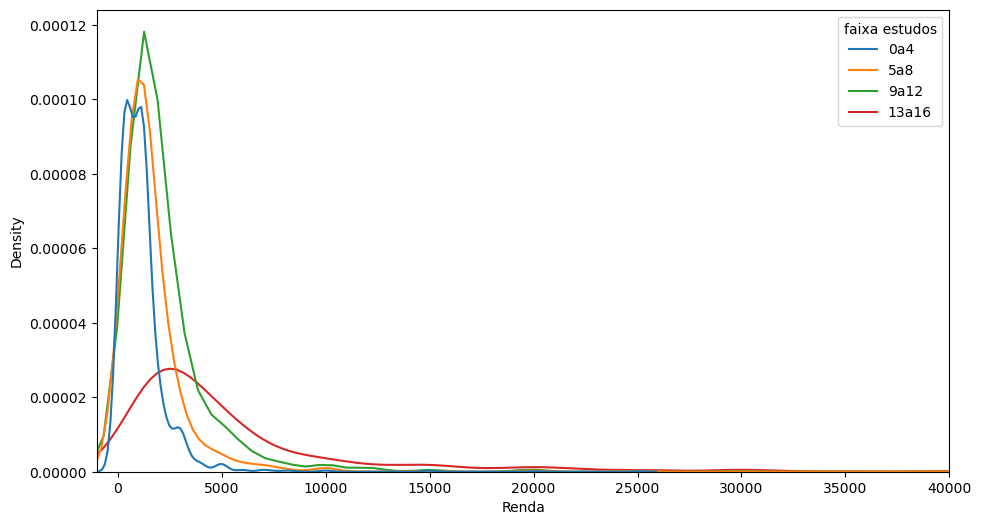

(Text(0.5, 24.0, 'Renda'), (-1000.0, 40000.0), None)

In [18]:
plt.figure(figsize=(11,6))
kdeplot(data=respFilhos.rename({'vd3005_r_c':'faixa estudos'},axis=1), 
        x=respFilhos['v403312_r'].dropna().astype(int), hue='faixa estudos')
plt.xlabel('Renda'), plt.xlim([-1000, 40000]), plt.show()

### Exclusão escolar

In [19]:
variaveis = ['upa','estrato','v1008', 'v2007', 'v2009', 'v2010', 'v403312','vd3005'] + \
            ['v4001', 'v4002', 'vd3004', 'v3002', 'v3002a']
idadeEscolar = pnad[
                        ((pnad['v2009'].astype(int)>3)&(pnad['v2009'].astype(int)<18))&
                        ((pnad['v2005']=='04')|(pnad['v2005']=='05'))&
                        (pnad['vd3004'].dropna().astype(int)<5)&
                        (pnad['v2010']!='9')
                                                                        ][variaveis]
idadeEscolar.reset_index(drop=True, inplace=True)

In [20]:
idadeEscolar['v2010'] = ['outros' if x=='3' or x=='5' else x for x in idadeEscolar['v2010']]
idadeEscolar['trabalha'] = ['1' if (x[0]=='1' or x[1]=='1') else '2' if (x[0]=='2' or x[1]=='2') else np.nan 
                                                 for x in zip(idadeEscolar['v4001'], idadeEscolar['v4002'])]
idadeEscolar.drop(['v4001', 'v4002'], axis=1, inplace=True)

In [21]:
idadeEscolar[idadeEscolar['v3002']=='2'].shape[0] / idadeEscolar.shape[0]

0.025090804091123235

In [22]:
tabelaContingencia = pd.crosstab(idadeEscolar[idadeEscolar['v2009'].astype(int)>13]['v3002'].rename('estuda'), 
            [idadeEscolar[idadeEscolar['v2009'].astype(int)>13]['trabalha'].rename(cat_dict(idadeEscolar, 'v3002')),
             idadeEscolar[idadeEscolar['v2009'].astype(int)>13]['v2007'].rename('sexo'),
             idadeEscolar[idadeEscolar['v2009'].astype(int)>13]['v2010'].rename('cor/raça')], normalize='index')\
                                                                .rename(cat_dict(idadeEscolar, 'v2007'), axis=1, level=1)\
                                                                .rename(cat_dict(idadeEscolar, 'v4001'), axis=1, level=0)\
                                                                .rename(cat_dict(idadeEscolar, 'v2010'), axis=1, level=2)\
                                                                .rename(cat_dict(idadeEscolar, 'v4001'))

In [23]:
tabelaContingencia = tabelaContingencia.transpose().sort_index()

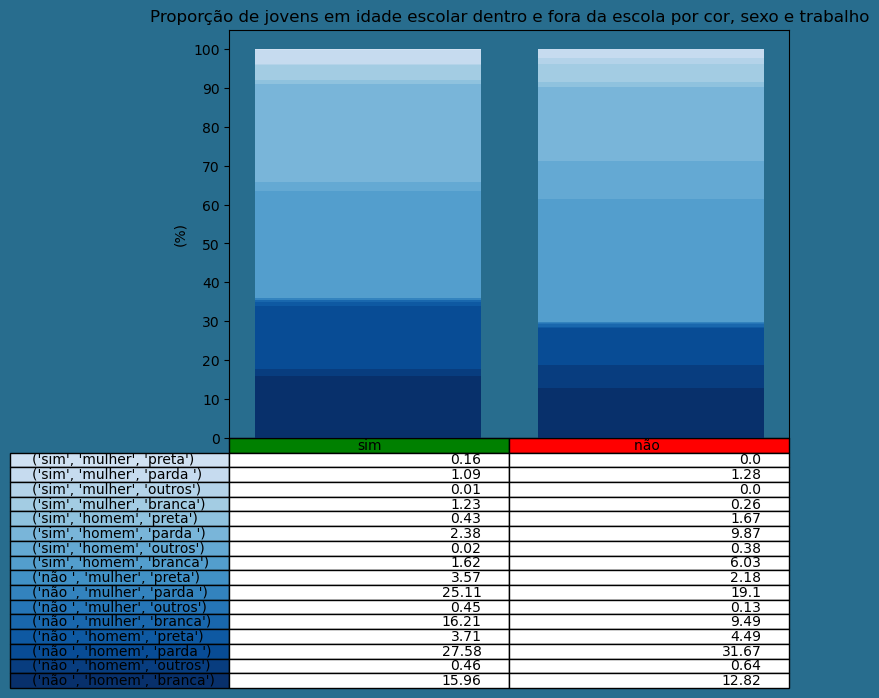

In [26]:
plt.figure(figsize=(8,6), facecolor='#286d8e'), plt.rcParams.update({'axes.facecolor':'#286d8e'})

colorsList = plt.cm.Blues(np.flip(np.linspace(0.2, 1, tabelaContingencia.shape[0])))
for col in tabelaContingencia.columns:
    y_offset = 0
    color = 0
    for index2 in tabelaContingencia.index.get_level_values(2).unique():
        for index1 in tabelaContingencia.index.get_level_values(1).unique():
            for index0 in tabelaContingencia.index.get_level_values(0).unique():
                y = tabelaContingencia.loc[index0, col][index1][index2]*100
                plt.bar(col, y, bottom=y_offset, color=colorsList[color])
                y_offset+=y
                color+=1

plt.xticks(['']), plt.yticks(np.arange(0,101,10)), plt.ylim([0,105]), plt.ylabel('(%)')
plt.title('Proporção de jovens em idade escolar dentro e fora da escola por cor, sexo e trabalho')
plt.table(cellText=(tabelaContingencia.values*100).round(2)[-1::-1],
          rowLabels=tabelaContingencia.index[-1::-1],
          rowColours=colorsList[-1::-1],
          colLabels=tabelaContingencia.columns,
          colColours=['green', 'red'])
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.show()